In [ ]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [5]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[1],
)

In [6]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [7]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [8]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Get CSP Weights

In [9]:
from cspnn.csp import CSP as CSP_base

In [10]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

csp = CSP_base(list(range(1, 5)), num_bands=1, num_windows=1)

In [11]:
signale = []
label = []
for sig, lbl in csp_dataloader:
    signale.append(sig)
    label.append(lbl["label"])
signale = torch.vstack(signale)
label = torch.stack(label)

In [12]:
signale.size(), label.size()

(torch.Size([288, 22, 1, 1, 1001]), torch.Size([288]))

In [13]:
weights = csp.calculate_weights(
    signals=signale.cpu().detach().numpy(), labels=label.cpu().detach().numpy()
)

In [14]:
weights.keys()

dict_keys(['label-1_band-0_window-0', 'label-2_band-0_window-0', 'label-3_band-0_window-0', 'label-4_band-0_window-0'])

## Model

In [15]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [16]:
import torch.optim as optim

In [17]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [18]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


torch.cuda.empty_cache()
net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [19]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [20]:
net.conv1.load_csp_weights(weights=weights, csp_template=csp.template)

## Train Loop

In [21]:
net = net.cuda()

In [22]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


9it [00:00, 17.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4113769266340468


Train -  [0.25, 0.0, 0.8016653806584362, 0.25, tensor(1.3899)]
Validation -  [0.25, 0.0, 0.7770061728395061, 0.25, tensor(1.3895)]

Epoch  1


9it [00:00, 44.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4101292424731784


Train -  [0.25, 0.0, 0.7670556841563787, 0.25, tensor(1.4038)]
Validation -  [0.25, 0.0, 0.7406603652263375, 0.25, tensor(1.4046)]

Epoch  2


9it [00:00, 41.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3920519351959229


Train -  [0.25, 0.0, 0.6889467592592593, 0.25, tensor(1.3932)]
Validation -  [0.25, 0.0, 0.6796875, 0.25, tensor(1.3935)]

Epoch  3


9it [00:00, 40.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3998139169481065


Train -  [0.3888888888888889, 0.18518518518518523, 0.7563014403292181, 0.3888888888888889, tensor(1.3839)]
Validation -  [0.3923611111111111, 0.18981481481481477, 0.7547421553497944, 0.3923611111111111, tensor(1.3828)]

Epoch  4


9it [00:00, 41.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3878358999888103


Train -  [0.4305555555555556, 0.2407407407407407, 0.8169528034979424, 0.4305555555555556, tensor(1.3688)]
Validation -  [0.3993055555555556, 0.19907407407407407, 0.8009580761316872, 0.3993055555555556, tensor(1.3700)]

Epoch  5


9it [00:00, 40.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3803377681308322


Train -  [0.2534722222222222, 0.00462962962962965, 0.8161168981481481, 0.2534722222222222, tensor(1.3709)]
Validation -  [0.28125, 0.04166666666666663, 0.8014885545267489, 0.28125, tensor(1.3704)]

Epoch  6


9it [00:00, 40.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3806106911765204


Train -  [0.3645833333333333, 0.1527777777777778, 0.8090920781893004, 0.36458333333333326, tensor(1.3787)]
Validation -  [0.3888888888888889, 0.18518518518518523, 0.7922453703703702, 0.3888888888888889, tensor(1.3763)]

Epoch  7


9it [00:00, 44.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.383442587322659


Train -  [0.25, 0.0, 0.8078542952674898, 0.25, tensor(1.3718)]
Validation -  [0.25, 0.0, 0.7918917181069958, 0.25, tensor(1.3723)]

Epoch  8


9it [00:00, 43.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3717470831341214


Train -  [0.2951388888888889, 0.06018518518518523, 0.8113586676954734, 0.2951388888888889, tensor(1.3660)]
Validation -  [0.28125, 0.04166666666666663, 0.7952112268518519, 0.28125, tensor(1.3692)]

Epoch  9


9it [00:00, 43.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3661606444252863


Train -  [0.2638888888888889, 0.01851851851851849, 0.8182388117283951, 0.2638888888888889, tensor(1.3629)]
Validation -  [0.2777777777777778, 0.03703703703703709, 0.802051183127572, 0.2777777777777778, tensor(1.3650)]

Epoch  10


9it [00:00, 41.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3402639892366197


Train -  [0.3854166666666667, 0.18055555555555558, 0.8203285751028806, 0.38541666666666663, tensor(1.3370)]
Validation -  [0.40625, 0.20833333333333337, 0.7876318158436214, 0.40625, tensor(1.3385)]

Epoch  11


9it [00:00, 38.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3355917003419664


Train -  [0.3680555555555556, 0.15740740740740744, 0.8170974794238683, 0.36805555555555564, tensor(1.3301)]
Validation -  [0.3923611111111111, 0.18981481481481477, 0.780446244855967, 0.3923611111111111, tensor(1.3318)]

Epoch  12


9it [00:00, 42.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3343313137690227


Train -  [0.4548611111111111, 0.27314814814814814, 0.8241544495884774, 0.4548611111111111, tensor(1.3091)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.7895769032921811, 0.4270833333333333, tensor(1.3156)]

Epoch  13


9it [00:00, 38.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.316860768530104


Train -  [0.4340277777777778, 0.24537037037037035, 0.827369470164609, 0.4340277777777778, tensor(1.3083)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.7907182355967078, 0.4097222222222222, tensor(1.3185)]

Epoch  14


9it [00:00, 47.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3313385115729437


Train -  [0.2743055555555556, 0.03240740740740744, 0.7132362397119342, 0.2743055555555556, tensor(1.3534)]
Validation -  [0.3298611111111111, 0.10648148148148151, 0.6916634516460907, 0.3298611111111111, tensor(1.3508)]

Epoch  15


9it [00:00, 40.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3347948392232258


Train -  [0.5069444444444444, 0.34259259259259256, 0.8271283436213992, 0.5069444444444444, tensor(1.2937)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7904931841563787, 0.4409722222222222, tensor(1.3011)]

Epoch  16


9it [00:00, 43.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2904589176177979


Train -  [0.4548611111111111, 0.27314814814814814, 0.8253600823045268, 0.4548611111111111, tensor(1.2851)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.7818447788065843, 0.4270833333333333, tensor(1.2976)]

Epoch  17


9it [00:00, 48.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2958579725689359


Train -  [0.4479166666666667, 0.26388888888888884, 0.8060699588477366, 0.4479166666666667, tensor(1.2950)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.7680684156378601, 0.4236111111111111, tensor(1.3053)]

Epoch  18


9it [00:00, 34.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2836405568652682


Train -  [0.4201388888888889, 0.22685185185185186, 0.8033532664609054, 0.4201388888888889, tensor(1.2854)]
Validation -  [0.3923611111111111, 0.18981481481481477, 0.7472350823045267, 0.3923611111111111, tensor(1.3043)]

Epoch  19


9it [00:00, 45.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2925462987687852


Train -  [0.5138888888888888, 0.35185185185185186, 0.8246367026748972, 0.5138888888888888, tensor(1.2819)]
Validation -  [0.4131944444444444, 0.21759259259259256, 0.7797550154320989, 0.4131944444444444, tensor(1.2962)]

Epoch  20


9it [00:00, 40.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2773145304785833


Train -  [0.4479166666666667, 0.26388888888888884, 0.8018100565843621, 0.4479166666666667, tensor(1.2760)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.7654320987654323, 0.4236111111111111, tensor(1.2880)]

Epoch  21


9it [00:00, 46.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2755796247058444


Train -  [0.4513888888888889, 0.2685185185185185, 0.8288966049382716, 0.4513888888888889, tensor(1.2606)]
Validation -  [0.4375, 0.25, 0.7634227109053499, 0.4375, tensor(1.2850)]

Epoch  22


9it [00:00, 45.38it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2639184527926974
Train -  [0.4513888888888889, 0.2685185185185185, 0.8334137088477366, 0.4513888888888889, tensor(1.2511)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.7688400205761317, 0.4340277777777778, tensor(1.2758)]

Epoch  23


9it [00:00, 39.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2706625329123602


Train -  [0.5034722222222222, 0.3379629629629629, 0.8345550411522634, 0.5034722222222222, tensor(1.2476)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.7770704732510288, 0.4340277777777778, tensor(1.2706)]

Epoch  24


9it [00:00, 39.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2612334092458088


Train -  [0.4583333333333333, 0.2777777777777778, 0.8042052469135802, 0.4583333333333333, tensor(1.2617)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7670878343621399, 0.4618055555555556, tensor(1.2745)]

Epoch  25


9it [00:00, 42.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.289747052722507


Train -  [0.4409722222222222, 0.25462962962962965, 0.8091242283950617, 0.4409722222222222, tensor(1.2693)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.7695955504115226, 0.4340277777777778, tensor(1.2808)]

Epoch  26


9it [00:00, 40.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2644013696246676


Train -  [0.4791666666666667, 0.3055555555555556, 0.8381558641975309, 0.4791666666666667, tensor(1.2389)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.774337705761317, 0.4409722222222222, tensor(1.2670)]

Epoch  27


9it [00:00, 45.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2487236393822565


Train -  [0.4305555555555556, 0.2407407407407407, 0.8078221450617283, 0.4305555555555556, tensor(1.2653)]
Validation -  [0.40625, 0.20833333333333337, 0.7443415637860082, 0.40625, tensor(1.2943)]

Epoch  28


9it [00:00, 45.36it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.262356440226237
Train -  [0.4548611111111111, 0.27314814814814814, 0.7902038323045266, 0.4548611111111111, tensor(1.2826)]
Validation -  [0.3611111111111111, 0.14814814814814814, 0.7416409465020577, 0.3611111111111111, tensor(1.3090)]

Epoch  29


9it [00:00, 40.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2701707151201036


Train -  [0.4791666666666667, 0.3055555555555556, 0.83471579218107, 0.4791666666666667, tensor(1.2421)]
Validation -  [0.4375, 0.25, 0.7659947273662551, 0.4375, tensor(1.2724)]

Epoch  30


9it [00:00, 41.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.243551214536031


Train -  [0.4756944444444444, 0.30092592592592593, 0.8364358281893005, 0.4756944444444444, tensor(1.2304)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7688078703703705, 0.4583333333333333, tensor(1.2620)]

Epoch  31


9it [00:00, 41.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2392566204071045


Train -  [0.5902777777777778, 0.4537037037037037, 0.8393936471193415, 0.5902777777777778, tensor(1.2308)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7793852880658435, 0.4513888888888889, tensor(1.2622)]

Epoch  32


9it [00:00, 39.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2468186881807115


Train -  [0.4791666666666667, 0.3055555555555556, 0.8142361111111112, 0.4791666666666667, tensor(1.2407)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7691454475308641, 0.4409722222222222, tensor(1.2670)]

Epoch  33


9it [00:00, 45.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2560484011967976


Train -  [0.4583333333333333, 0.2777777777777778, 0.7807034465020576, 0.4583333333333333, tensor(1.2603)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7542920524691357, 0.4444444444444444, tensor(1.2729)]

Epoch  34


9it [00:00, 37.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2342932489183214


Train -  [0.4444444444444444, 0.2592592592592593, 0.8288323045267489, 0.4444444444444444, tensor(1.2347)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7748360339506173, 0.4444444444444444, tensor(1.2609)]

Epoch  35


9it [00:00, 42.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2376753356721666


Train -  [0.4895833333333333, 0.3194444444444444, 0.8189621913580247, 0.4895833333333333, tensor(1.2308)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7726980452674898, 0.4513888888888889, tensor(1.2580)]

Epoch  36


9it [00:00, 35.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.228072656525506


Train -  [0.4652777777777778, 0.2870370370370371, 0.7786458333333333, 0.4652777777777778, tensor(1.2594)]
Validation -  [0.46875, 0.29166666666666663, 0.7534400720164609, 0.46875, tensor(1.2691)]

Epoch  37


9it [00:00, 41.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2622341844770644


Train -  [0.4756944444444444, 0.30092592592592593, 0.8256655092592593, 0.4756944444444444, tensor(1.2245)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7705118312757202, 0.4513888888888889, tensor(1.2555)]

Epoch  38


9it [00:00, 42.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.238179326057434


Train -  [0.3229166666666667, 0.09722222222222221, 0.727173353909465, 0.3229166666666667, tensor(1.3562)]
Validation -  [0.3472222222222222, 0.12962962962962965, 0.7042663323045267, 0.3472222222222222, tensor(1.3593)]

Epoch  39


9it [00:00, 43.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3055158588621352


Train -  [0.5243055555555556, 0.3657407407407407, 0.8278677983539096, 0.5243055555555556, tensor(1.2383)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.7653356481481481, 0.4270833333333333, tensor(1.2743)]

Epoch  40


9it [00:00, 40.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2477322419484456


Train -  [0.4479166666666667, 0.26388888888888884, 0.7732767489711935, 0.4479166666666667, tensor(1.2688)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.7482317386831275, 0.4236111111111111, tensor(1.2884)]

Epoch  41


9it [00:00, 39.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2554953495661418


Train -  [0.3645833333333333, 0.1527777777777778, 0.7391332304526749, 0.36458333333333326, tensor(1.2924)]
Validation -  [0.3958333333333333, 0.19444444444444442, 0.7271412037037037, 0.3958333333333333, tensor(1.2913)]

Epoch  42


9it [00:00, 39.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2455748981899686


Train -  [0.4722222222222222, 0.2962962962962963, 0.817065329218107, 0.4722222222222222, tensor(1.2308)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7697563014403292, 0.4756944444444444, tensor(1.2557)]

Epoch  43


9it [00:00, 40.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2333882517284818


Train -  [0.5520833333333334, 0.4027777777777778, 0.8308738425925926, 0.5520833333333334, tensor(1.2159)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7582786779835391, 0.4513888888888889, tensor(1.2588)]

Epoch  44


9it [00:00, 41.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2220904032389324


Train -  [0.53125, 0.375, 0.8364197530864198, 0.53125, tensor(1.2118)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7652713477366255, 0.4479166666666667, tensor(1.2558)]

Epoch  45


9it [00:00, 36.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2548603084352281


Train -  [0.4340277777777778, 0.24537037037037035, 0.8235114454732511, 0.4340277777777778, tensor(1.2452)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.7733571244855968, 0.4097222222222222, tensor(1.2690)]

Epoch  46


9it [00:00, 45.72it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2244348790910509
Train -  [0.4756944444444444, 0.30092592592592593, 0.8288644547325101, 0.4756944444444444, tensor(1.2402)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.757249871399177, 0.4201388888888889, tensor(1.2791)]

Epoch  47


9it [00:00, 45.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2494703398810492


Train -  [0.4548611111111111, 0.27314814814814814, 0.7891911008230452, 0.4548611111111111, tensor(1.2759)]
Validation -  [0.3958333333333333, 0.19444444444444442, 0.7315618569958848, 0.3958333333333333, tensor(1.3064)]

Epoch  48


9it [00:00, 47.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2842124435636733


Train -  [0.4895833333333333, 0.3194444444444444, 0.8199427726337449, 0.4895833333333333, tensor(1.2449)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.748681841563786, 0.4305555555555556, tensor(1.2831)]

Epoch  49


9it [00:00, 38.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2259658177693684


Train -  [0.5520833333333334, 0.4027777777777778, 0.8339441872427984, 0.5520833333333334, tensor(1.2108)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7612847222222223, 0.4409722222222222, tensor(1.2565)]

Epoch  50


9it [00:00, 42.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.222046348783705


Train -  [0.5763888888888888, 0.43518518518518523, 0.8398598251028806, 0.5763888888888888, tensor(1.2063)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7700295781893005, 0.4409722222222222, tensor(1.2528)]

Epoch  51


9it [00:00, 40.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2546686728795369


Train -  [0.4340277777777778, 0.24537037037037035, 0.7742573302469136, 0.4340277777777778, tensor(1.2827)]
Validation -  [0.3958333333333333, 0.19444444444444442, 0.7282021604938271, 0.3958333333333333, tensor(1.3097)]

Epoch  52


9it [00:00, 39.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.227591700024075


Train -  [0.5277777777777778, 0.37037037037037035, 0.818994341563786, 0.5277777777777778, tensor(1.2443)]
Validation -  [0.3993055555555556, 0.19907407407407407, 0.7613972479423868, 0.3993055555555556, tensor(1.2798)]

Epoch  53


9it [00:00, 37.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.222580009036594


Train -  [0.5243055555555556, 0.3657407407407407, 0.8378504372427985, 0.5243055555555556, tensor(1.2016)]
Validation -  [0.4375, 0.25, 0.771604938271605, 0.4375, tensor(1.2484)]

Epoch  54


9it [00:00, 48.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2213911480373807


Train -  [0.5138888888888888, 0.35185185185185186, 0.8358731995884774, 0.5138888888888888, tensor(1.2090)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7625064300411522, 0.4444444444444444, tensor(1.2560)]

Epoch  55


9it [00:00, 40.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2131444878048367


Train -  [0.4826388888888889, 0.31018518518518523, 0.8085776748971194, 0.4826388888888889, tensor(1.2502)]
Validation -  [0.3888888888888889, 0.18518518518518523, 0.7534882973251029, 0.3888888888888889, tensor(1.2875)]

Epoch  56


9it [00:00, 39.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.246461656358507


Train -  [0.4652777777777778, 0.2870370370370371, 0.7993344907407407, 0.4652777777777778, tensor(1.2560)]
Validation -  [0.3958333333333333, 0.19444444444444442, 0.7404513888888888, 0.3958333333333333, tensor(1.2892)]

Epoch  57


9it [00:00, 41.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2536756594975789


Train -  [0.4131944444444444, 0.21759259259259256, 0.7739358281893004, 0.4131944444444444, tensor(1.2775)]
Validation -  [0.3993055555555556, 0.19907407407407407, 0.7332658179012346, 0.3993055555555556, tensor(1.3044)]

Epoch  58


9it [00:00, 40.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2434910535812378


Train -  [0.4895833333333333, 0.3194444444444444, 0.84252829218107, 0.4895833333333333, tensor(1.2136)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.7749807098765433, 0.4166666666666667, tensor(1.2605)]

Epoch  59


9it [00:00, 44.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2020539840062459


Train -  [0.5243055555555556, 0.3657407407407407, 0.8371109825102881, 0.5243055555555556, tensor(1.2012)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7781475051440327, 0.4791666666666667, tensor(1.2414)]

Epoch  60


9it [00:00, 38.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2112613519032795


Train -  [0.5729166666666666, 0.4305555555555556, 0.8355356224279835, 0.5729166666666666, tensor(1.1942)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7797550154320989, 0.4618055555555556, tensor(1.2388)]

Epoch  61


9it [00:00, 41.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2037274307674832


Train -  [0.5451388888888888, 0.3935185185185185, 0.8471096965020577, 0.5451388888888888, tensor(1.1938)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7789351851851851, 0.4409722222222222, tensor(1.2466)]

Epoch  62


9it [00:00, 39.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2085930506388347


Train -  [0.5763888888888888, 0.43518518518518523, 0.8465470679012346, 0.5763888888888888, tensor(1.1885)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7759612911522633, 0.4513888888888889, tensor(1.2407)]

Epoch  63


9it [00:00, 42.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2046633296542697


Train -  [0.5104166666666666, 0.3472222222222222, 0.8475597993827161, 0.5104166666666666, tensor(1.2020)]
Validation -  [0.4375, 0.25, 0.779128086419753, 0.4375, tensor(1.2539)]

Epoch  64


9it [00:00, 43.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2042857673433092


Train -  [0.5555555555555556, 0.40740740740740744, 0.8440875771604938, 0.5555555555555556, tensor(1.1878)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.77612204218107, 0.4756944444444444, tensor(1.2383)]

Epoch  65


9it [00:00, 40.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1993858019510906


Train -  [0.5243055555555556, 0.3657407407407407, 0.8300057870370371, 0.5243055555555556, tensor(1.1960)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7780189043209876, 0.4722222222222222, tensor(1.2385)]

Epoch  66


9it [00:00, 41.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.196482287512885


Train -  [0.5555555555555556, 0.40740740740740744, 0.846900720164609, 0.5555555555555556, tensor(1.1909)]
Validation -  [0.46875, 0.29166666666666663, 0.7736625514403292, 0.46875, tensor(1.2452)]

Epoch  67


9it [00:00, 35.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2006840705871582


Train -  [0.5034722222222222, 0.3379629629629629, 0.8460326646090535, 0.5034722222222222, tensor(1.2067)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.7738072273662553, 0.4305555555555556, tensor(1.2584)]

Epoch  68


9it [00:00, 45.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1904834376441107


Train -  [0.5659722222222222, 0.4212962962962963, 0.849537037037037, 0.5659722222222222, tensor(1.1916)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7824877829218106, 0.4861111111111111, tensor(1.2419)]

Epoch  69


9it [00:00, 43.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1998631556828816


Train -  [0.4965277777777778, 0.3287037037037037, 0.8070987654320989, 0.4965277777777778, tensor(1.2229)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7670717592592593, 0.4652777777777778, tensor(1.2451)]

Epoch  70


9it [00:00, 44.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.241863833533393


Train -  [0.5625, 0.41666666666666663, 0.8262602880658436, 0.5625, tensor(1.2003)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7779385288065843, 0.4548611111111111, tensor(1.2397)]

Epoch  71


9it [00:00, 42.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.219795094596015


Train -  [0.4826388888888889, 0.31018518518518523, 0.8171457047325102, 0.4826388888888889, tensor(1.2188)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7721193415637859, 0.4965277777777778, tensor(1.2452)]

Epoch  72


9it [00:00, 42.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2300459543863933


Train -  [0.5381944444444444, 0.3842592592592593, 0.8455664866255144, 0.5381944444444444, tensor(1.1931)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7808963477366255, 0.4548611111111111, tensor(1.2484)]

Epoch  73


9it [00:00, 43.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2441493802600436


Train -  [0.5486111111111112, 0.39814814814814814, 0.8379790380658436, 0.5486111111111112, tensor(1.2106)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.7788869598765433, 0.4305555555555556, tensor(1.2587)]

Epoch  74


9it [00:00, 43.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2258969412909613


Train -  [0.3888888888888889, 0.18518518518518523, 0.7618795010288066, 0.3888888888888889, tensor(1.2970)]
Validation -  [0.3715277777777778, 0.1620370370370371, 0.7314171810699588, 0.3715277777777778, tensor(1.3142)]

Epoch  75


9it [00:00, 43.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2444563971625433


Train -  [0.4340277777777778, 0.24537037037037035, 0.8471096965020576, 0.4340277777777778, tensor(1.2602)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.7928401491769548, 0.4097222222222222, tensor(1.2952)]

Epoch  76


9it [00:00, 40.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2392864757113986


Train -  [0.5798611111111112, 0.43981481481481477, 0.8432034465020576, 0.5798611111111112, tensor(1.1769)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7847382973251029, 0.4583333333333333, tensor(1.2303)]

Epoch  77


9it [00:00, 41.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2085636324352689


Train -  [0.5277777777777778, 0.37037037037037035, 0.8323849022633745, 0.5277777777777778, tensor(1.2014)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.776170267489712, 0.4513888888888889, tensor(1.2409)]

Epoch  78


9it [00:00, 45.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.21063408586714


Train -  [0.5451388888888888, 0.3935185185185185, 0.8302469135802468, 0.5451388888888888, tensor(1.1931)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.780542695473251, 0.4652777777777778, tensor(1.2389)]

Epoch  79


9it [00:00, 42.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1940108670128717


Train -  [0.4722222222222222, 0.2962962962962963, 0.8511123971193415, 0.4722222222222222, tensor(1.2004)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7877443415637859, 0.4583333333333333, tensor(1.2489)]

Epoch  80


9it [00:00, 41.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2111898793114557


Train -  [0.5173611111111112, 0.3564814814814815, 0.8289609053497943, 0.5173611111111112, tensor(1.2152)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7752218364197531, 0.4548611111111111, tensor(1.2613)]

Epoch  81


9it [00:00, 43.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2233603133095636


Train -  [0.5277777777777778, 0.37037037037037035, 0.8401009516460904, 0.5277777777777778, tensor(1.2121)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7747235082304528, 0.4444444444444444, tensor(1.2649)]

Epoch  82


9it [00:00, 39.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2223381731245253


Train -  [0.4409722222222222, 0.25462962962962965, 0.8142521862139918, 0.4409722222222222, tensor(1.2521)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.761107896090535, 0.4409722222222222, tensor(1.2793)]

Epoch  83


9it [00:00, 40.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2052476803461711


Train -  [0.5868055555555556, 0.44907407407407407, 0.8512409979423868, 0.5868055555555556, tensor(1.1710)]
Validation -  [0.46875, 0.29166666666666663, 0.7782600308641976, 0.46875, tensor(1.2324)]

Epoch  84


9it [00:00, 43.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1853863663143582


Train -  [0.5138888888888888, 0.35185185185185186, 0.8493762860082305, 0.5138888888888888, tensor(1.1969)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7769418724279835, 0.4444444444444444, tensor(1.2535)]

Epoch  85


9it [00:00, 36.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1974090337753296


Train -  [0.59375, 0.45833333333333337, 0.850244341563786, 0.59375, tensor(1.1706)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7878086419753085, 0.4548611111111111, tensor(1.2319)]

Epoch  86


9it [00:00, 40.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1783532831403944


Train -  [0.5520833333333334, 0.4027777777777778, 0.850147890946502, 0.5520833333333334, tensor(1.1820)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7761381172839507, 0.4756944444444444, tensor(1.2404)]

Epoch  87


9it [00:00, 43.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2062924570507474


Train -  [0.5868055555555556, 0.44907407407407407, 0.8554848251028807, 0.5868055555555556, tensor(1.1762)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7845936213991769, 0.4791666666666667, tensor(1.2408)]

Epoch  88


9it [00:00, 34.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.230435848236084


Train -  [0.5347222222222222, 0.37962962962962965, 0.8166634516460906, 0.5347222222222222, tensor(1.2021)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7737429269547325, 0.4652777777777778, tensor(1.2378)]

Epoch  89


9it [00:00, 38.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.211414681540595


Train -  [0.5381944444444444, 0.3842592592592593, 0.8495691872427984, 0.5381944444444444, tensor(1.1839)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7758969907407408, 0.4756944444444444, tensor(1.2361)]

Epoch  90


9it [00:00, 43.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1987238195207384


Train -  [0.5277777777777778, 0.37037037037037035, 0.8458558384773662, 0.5277777777777778, tensor(1.2102)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.7829218106995883, 0.4305555555555556, tensor(1.2677)]

Epoch  91


9it [00:00, 40.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2375887632369995


Train -  [0.4930555555555556, 0.32407407407407407, 0.8100565843621399, 0.4930555555555556, tensor(1.2187)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7711709104938271, 0.4479166666666667, tensor(1.2556)]

Epoch  92


9it [00:00, 41.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.192196660571628


Train -  [0.4548611111111111, 0.27314814814814814, 0.8433802726337447, 0.4548611111111111, tensor(1.2334)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.7846096965020576, 0.4201388888888889, tensor(1.2665)]

Epoch  93


9it [00:00, 41.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1920148664050632


Train -  [0.4826388888888889, 0.31018518518518523, 0.8344103652263375, 0.4826388888888889, tensor(1.2161)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7737911522633745, 0.4583333333333333, tensor(1.2593)]

Epoch  94


9it [00:00, 38.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2490462859471638


Train -  [0.5277777777777778, 0.37037037037037035, 0.8317258230452677, 0.5277777777777778, tensor(1.2149)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7748038837448559, 0.4444444444444444, tensor(1.2662)]

Epoch  95


9it [00:00, 42.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.23876957098643


Train -  [0.5277777777777778, 0.37037037037037035, 0.8328993055555556, 0.5277777777777778, tensor(1.2147)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7702546296296295, 0.4444444444444444, tensor(1.2639)]

Epoch  96


9it [00:00, 39.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2232116195890639


Train -  [0.5, 0.33333333333333337, 0.8251028806584362, 0.5, tensor(1.2328)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.7525720164609053, 0.4166666666666667, tensor(1.2787)]

Epoch  97


9it [00:00, 46.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2584351301193237


Train -  [0.3715277777777778, 0.1620370370370371, 0.7427822788065843, 0.3715277777777778, tensor(1.3457)]
Validation -  [0.3506944444444444, 0.1342592592592593, 0.7148115997942386, 0.3506944444444444, tensor(1.3588)]

Epoch  98


9it [00:00, 38.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2935382260216608


Train -  [0.53125, 0.375, 0.8368055555555556, 0.53125, tensor(1.2123)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7690489969135803, 0.4444444444444444, tensor(1.2641)]

Epoch  99


9it [00:00, 41.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2532930374145508


Train -  [0.4652777777777778, 0.2870370370370371, 0.7993827160493827, 0.4652777777777778, tensor(1.2394)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7629886831275721, 0.4409722222222222, tensor(1.2698)]

Epoch  100


9it [00:00, 44.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2340732945336237


Train -  [0.4548611111111111, 0.27314814814814814, 0.7908629115226338, 0.4548611111111111, tensor(1.2463)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7605613425925926, 0.4513888888888889, tensor(1.2732)]

Epoch  101


9it [00:00, 44.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2323904699749417


Train -  [0.5208333333333334, 0.36111111111111116, 0.8473668981481481, 0.5208333333333334, tensor(1.2051)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.776218492798354, 0.4340277777777778, tensor(1.2646)]

Epoch  102


9it [00:00, 45.69it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2205205361048381
Train -  [0.5277777777777778, 0.37037037037037035, 0.8245081018518519, 0.5277777777777778, tensor(1.2015)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7585358796296298, 0.4722222222222222, tensor(1.2544)]

Epoch  103


9it [00:00, 39.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1641487545437283


Train -  [0.53125, 0.375, 0.850196116255144, 0.53125, tensor(1.1863)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7752539866255144, 0.4409722222222222, tensor(1.2508)]

Epoch  104


9it [00:00, 41.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.198751277393765


Train -  [0.5243055555555556, 0.3657407407407407, 0.8551472479423867, 0.5243055555555556, tensor(1.1923)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7925829475308642, 0.4513888888888889, tensor(1.2491)]

Epoch  105


9it [00:00, 48.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2099823024537828


Train -  [0.5277777777777778, 0.37037037037037035, 0.8351015946502058, 0.5277777777777778, tensor(1.2196)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7613490226337448, 0.4444444444444444, tensor(1.2727)]

Epoch  106


9it [00:00, 43.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.234258320596483


Train -  [0.5347222222222222, 0.37962962962962965, 0.8337191358024691, 0.5347222222222222, tensor(1.2132)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7629565329218106, 0.4444444444444444, tensor(1.2656)]

Epoch  107


9it [00:00, 35.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2266379992167156


Train -  [0.4895833333333333, 0.3194444444444444, 0.8098958333333333, 0.4895833333333333, tensor(1.2426)]
Validation -  [0.4375, 0.25, 0.7411104681069958, 0.4375, tensor(1.2844)]

Epoch  108


9it [00:00, 40.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2678947316275702


Train -  [0.5, 0.33333333333333337, 0.8269675925925926, 0.5, tensor(1.2313)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.7548546810699588, 0.4305555555555556, tensor(1.2804)]

Epoch  109


9it [00:00, 40.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2655300564236112


Train -  [0.4548611111111111, 0.27314814814814814, 0.7718460648148149, 0.4548611111111111, tensor(1.2760)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.7433609825102881, 0.4201388888888889, tensor(1.3022)]

Epoch  110


9it [00:00, 42.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.26616813076867


Train -  [0.4756944444444444, 0.30092592592592593, 0.801488554526749, 0.4756944444444444, tensor(1.2394)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7621527777777777, 0.4548611111111111, tensor(1.2703)]

Epoch  111


9it [00:00, 44.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.239202128516303


Train -  [0.5173611111111112, 0.3564814814814815, 0.8334780092592593, 0.5173611111111112, tensor(1.2218)]
Validation -  [0.4375, 0.25, 0.7607542438271605, 0.4375, tensor(1.2780)]

Epoch  112


9it [00:00, 43.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2204047309027777


Train -  [0.5069444444444444, 0.34259259259259256, 0.8296039094650207, 0.5069444444444444, tensor(1.2146)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7619598765432098, 0.4618055555555556, tensor(1.2632)]

Epoch  113


9it [00:00, 41.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2293093866772122


Train -  [0.4791666666666667, 0.3055555555555556, 0.8005240483539096, 0.4791666666666667, tensor(1.2365)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7635030864197532, 0.4513888888888889, tensor(1.2706)]

Epoch  114


9it [00:00, 45.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2263161738713582


Train -  [0.4652777777777778, 0.2870370370370371, 0.7932098765432098, 0.4652777777777778, tensor(1.2437)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7591628086419753, 0.4444444444444444, tensor(1.2731)]

Epoch  115


9it [00:00, 38.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2340097162458632


Train -  [0.5208333333333334, 0.36111111111111116, 0.8327546296296297, 0.5208333333333334, tensor(1.2082)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7701421039094651, 0.4479166666666667, tensor(1.2620)]

Epoch  116


9it [00:00, 36.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2168324788411458


Train -  [0.4895833333333333, 0.3194444444444444, 0.833960262345679, 0.4895833333333333, tensor(1.2309)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.7598218878600823, 0.4201388888888889, tensor(1.2808)]

Epoch  117


9it [00:00, 43.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2291283739937677


Train -  [0.4513888888888889, 0.2685185185185185, 0.7893518518518519, 0.4513888888888889, tensor(1.2384)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7419463734567902, 0.4409722222222222, tensor(1.2803)]

Epoch  118


9it [00:00, 48.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2285067902670965


Train -  [0.5069444444444444, 0.34259259259259256, 0.819235468106996, 0.5069444444444444, tensor(1.2099)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7581661522633745, 0.4479166666666667, tensor(1.2625)]

Epoch  119


9it [00:00, 43.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2124442921744452


Train -  [0.5, 0.33333333333333337, 0.8398115997942387, 0.5, tensor(1.1915)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7801568930041152, 0.4965277777777778, tensor(1.2354)]

Epoch  120


9it [00:00, 36.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.189127352502611


Train -  [0.5347222222222222, 0.37962962962962965, 0.8499067644032922, 0.5347222222222222, tensor(1.1950)]
Validation -  [0.4375, 0.25, 0.7776491769547326, 0.4375, tensor(1.2612)]

Epoch  121


9it [00:00, 43.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2282725705040827


Train -  [0.4930555555555556, 0.32407407407407407, 0.8273373199588476, 0.4930555555555556, tensor(1.2272)]
Validation -  [0.4375, 0.25, 0.7553530092592593, 0.4375, tensor(1.2739)]

Epoch  122


9it [00:00, 44.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.195326222313775


Train -  [0.5451388888888888, 0.3935185185185185, 0.8358249742798355, 0.5451388888888888, tensor(1.1927)]
Validation -  [0.4131944444444444, 0.21759259259259256, 0.77075295781893, 0.4131944444444444, tensor(1.2590)]

Epoch  123


9it [00:00, 42.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1679058074951172


Train -  [0.5659722222222222, 0.4212962962962963, 0.8528645833333333, 0.5659722222222222, tensor(1.1705)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7792566872427984, 0.4722222222222222, tensor(1.2406)]

Epoch  124


9it [00:00, 38.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.191362566418118


Train -  [0.5416666666666666, 0.38888888888888884, 0.8282857510288066, 0.5416666666666666, tensor(1.1985)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.7678112139917697, 0.4201388888888889, tensor(1.2604)]

Epoch  125


9it [00:00, 39.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2052447928322687


Train -  [0.5, 0.33333333333333337, 0.8129018775720165, 0.5, tensor(1.2390)]
Validation -  [0.4375, 0.25, 0.7524273405349795, 0.4375, tensor(1.2713)]

Epoch  126


9it [00:00, 42.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2245589759614732


Train -  [0.5590277777777778, 0.4120370370370371, 0.8584265689300411, 0.5590277777777778, tensor(1.1745)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.796167695473251, 0.4791666666666667, tensor(1.2391)]

Epoch  127


9it [00:00, 35.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1863153643078275


Train -  [0.4652777777777778, 0.2870370370370371, 0.8370949074074074, 0.4652777777777778, tensor(1.2073)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7823752572016461, 0.4618055555555556, tensor(1.2429)]

Epoch  128


9it [00:00, 31.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1838201681772869


Train -  [0.5277777777777778, 0.37037037037037035, 0.8530414094650205, 0.5277777777777778, tensor(1.1872)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7791280864197532, 0.4652777777777778, tensor(1.2478)]

Epoch  129


9it [00:00, 25.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1797626813252766


Train -  [0.5833333333333334, 0.4444444444444444, 0.8619630915637859, 0.5833333333333334, tensor(1.1581)]
Validation -  [0.46875, 0.29166666666666663, 0.7929365997942387, 0.46875, tensor(1.2338)]

Epoch  130


9it [00:00, 47.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2061530086729262


Train -  [0.5138888888888888, 0.35185185185185186, 0.834571116255144, 0.5138888888888888, tensor(1.2145)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7705439814814815, 0.4548611111111111, tensor(1.2609)]

Epoch  131


9it [00:00, 44.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2152272197935317


Train -  [0.5277777777777778, 0.37037037037037035, 0.837914737654321, 0.5277777777777778, tensor(1.2136)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7781635802469136, 0.4409722222222222, tensor(1.2712)]

Epoch  132


9it [00:00, 37.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2192450364430745


Train -  [0.5208333333333334, 0.36111111111111116, 0.8346032664609053, 0.5208333333333334, tensor(1.2089)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.7678112139917694, 0.4583333333333333, tensor(1.2604)]

Epoch  133


9it [00:00, 40.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2264566289054022


Train -  [0.5243055555555556, 0.3657407407407407, 0.8273212448559671, 0.5243055555555556, tensor(1.2177)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7563175154320987, 0.4513888888888889, tensor(1.2691)]

Epoch  134


9it [00:00, 42.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2353915373484294


Train -  [0.4583333333333333, 0.2777777777777778, 0.7945923353909465, 0.4583333333333333, tensor(1.2600)]
Validation -  [0.4375, 0.25, 0.7366898148148149, 0.4375, tensor(1.2942)]

Epoch  135


9it [00:00, 46.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2619773546854656


Train -  [0.5277777777777778, 0.37037037037037035, 0.8379308127572016, 0.5277777777777778, tensor(1.2174)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7674414866255144, 0.4513888888888889, tensor(1.2738)]

Epoch  136


9it [00:00, 40.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2268549468782213


Train -  [0.5277777777777778, 0.37037037037037035, 0.8323366769547326, 0.5277777777777778, tensor(1.2121)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7616544495884774, 0.4444444444444444, tensor(1.2633)]

Epoch  137


9it [00:00, 40.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2281483676698473


Train -  [0.53125, 0.375, 0.8345228909465021, 0.53125, tensor(1.2086)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.778758359053498, 0.4548611111111111, tensor(1.2648)]

Epoch  138


9it [00:00, 44.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2356217437320285


Train -  [0.4375, 0.25, 0.755979938271605, 0.4375, tensor(1.2840)]
Validation -  [0.4375, 0.25, 0.7353555812757202, 0.4375, tensor(1.2946)]

Epoch  139


9it [00:00, 42.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2904184659322102


Train -  [0.4756944444444444, 0.30092592592592593, 0.82544045781893, 0.4756944444444444, tensor(1.2550)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.7568319187242798, 0.4166666666666667, tensor(1.2946)]

Epoch  140


9it [00:00, 46.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.271540602048238


Train -  [0.4722222222222222, 0.2962962962962963, 0.8066647376543209, 0.4722222222222222, tensor(1.2564)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.7425893775720165, 0.4270833333333333, tensor(1.2876)]

Epoch  141


9it [00:00, 42.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.234948952992757


Train -  [0.6076388888888888, 0.47685185185185186, 0.8564011059670782, 0.6076388888888888, tensor(1.1530)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7849151234567902, 0.4722222222222222, tensor(1.2263)]

Epoch  142


9it [00:00, 42.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1771910190582275


Train -  [0.5347222222222222, 0.37962962962962965, 0.8415316358024691, 0.5347222222222222, tensor(1.1838)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7816358024691358, 0.4513888888888889, tensor(1.2473)]

Epoch  143


9it [00:00, 40.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2013305160734389


Train -  [0.5520833333333334, 0.4027777777777778, 0.8403581532921811, 0.5520833333333334, tensor(1.1698)]
Validation -  [0.5, 0.33333333333333337, 0.7811053240740742, 0.5, tensor(1.2247)]

Epoch  144


9it [00:00, 43.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2133000426822238


Train -  [0.5277777777777778, 0.37037037037037035, 0.8495691872427984, 0.5277777777777778, tensor(1.1892)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7756558641975309, 0.4479166666666667, tensor(1.2539)]

Epoch  145


9it [00:00, 43.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.207193374633789


Train -  [0.5034722222222222, 0.3379629629629629, 0.8190104166666666, 0.5034722222222222, tensor(1.2202)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7735821759259258, 0.4479166666666667, tensor(1.2653)]

Epoch  146


9it [00:00, 33.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2354968123965793


Train -  [0.5208333333333334, 0.36111111111111116, 0.8354713220164609, 0.5208333333333334, tensor(1.2091)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7707368827160495, 0.4513888888888889, tensor(1.2601)]

Epoch  147


9it [00:00, 44.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2207586765289307


Train -  [0.5243055555555556, 0.3657407407407407, 0.840647505144033, 0.5243055555555556, tensor(1.2116)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7708172582304528, 0.4479166666666667, tensor(1.2727)]

Epoch  148


9it [00:00, 43.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2157470650143094


Train -  [0.5277777777777778, 0.37037037037037035, 0.8305684156378601, 0.5277777777777778, tensor(1.2152)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.758937757201646, 0.4513888888888889, tensor(1.2692)]

Epoch  149


9it [00:00, 48.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2130868169996474


Train -  [0.5347222222222222, 0.37962962962962965, 0.8433481224279836, 0.5347222222222222, tensor(1.1995)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7705118312757202, 0.4479166666666667, tensor(1.2616)]

Epoch  150


9it [00:00, 47.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.20320905579461


Train -  [0.4826388888888889, 0.31018518518518523, 0.841579861111111, 0.4826388888888889, tensor(1.2390)]
Validation -  [0.4375, 0.25, 0.7872620884773662, 0.4375, tensor(1.2754)]

Epoch  151


9it [00:00, 40.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2041631672117445


Train -  [0.4618055555555556, 0.28240740740740744, 0.8075649434156379, 0.4618055555555556, tensor(1.2565)]
Validation -  [0.4131944444444444, 0.21759259259259256, 0.75, 0.4131944444444444, tensor(1.2879)]

Epoch  152


9it [00:00, 40.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2582738796869914


Train -  [0.4930555555555556, 0.32407407407407407, 0.8295556841563786, 0.4930555555555556, tensor(1.2208)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7635995370370371, 0.4513888888888889, tensor(1.2630)]

Epoch  153


9it [00:00, 41.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2697107791900635


Train -  [0.34375, 0.125, 0.7260641718106996, 0.34375, tensor(1.3501)]
Validation -  [0.3923611111111111, 0.18981481481481477, 0.7062114197530864, 0.3923611111111111, tensor(1.3331)]

Epoch  154


9it [00:00, 43.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2709932857089572


Train -  [0.4513888888888889, 0.2685185185185185, 0.7779546039094651, 0.4513888888888889, tensor(1.2698)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.7288290895061729, 0.4201388888888889, tensor(1.3005)]

Epoch  155


9it [00:00, 35.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2413626114527385


Train -  [0.4756944444444444, 0.30092592592592593, 0.8161972736625515, 0.4756944444444444, tensor(1.2244)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7666698816872428, 0.4548611111111111, tensor(1.2632)]

Epoch  156


9it [00:00, 48.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2357821199629042


Train -  [0.4826388888888889, 0.31018518518518523, 0.7961355452674898, 0.4826388888888889, tensor(1.2445)]
Validation -  [0.4375, 0.25, 0.7629243827160493, 0.4375, tensor(1.2762)]

Epoch  157


9it [00:00, 37.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2257224983639188


Train -  [0.53125, 0.375, 0.8300700874485596, 0.53125, tensor(1.2104)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.762844007201646, 0.4583333333333333, tensor(1.2598)]

Epoch  158


9it [00:00, 47.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2096119191911485


Train -  [0.4895833333333333, 0.3194444444444444, 0.8206661522633745, 0.4895833333333333, tensor(1.2436)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.7518807870370371, 0.4305555555555556, tensor(1.2902)]

Epoch  159


9it [00:00, 32.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.234148833486769


Train -  [0.4722222222222222, 0.2962962962962963, 0.7966981738683128, 0.4722222222222222, tensor(1.2461)]
Validation -  [0.46875, 0.29166666666666663, 0.7582947530864197, 0.46875, tensor(1.2755)]

Epoch  160


9it [00:00, 35.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.25483504931132


Train -  [0.4826388888888889, 0.31018518518518523, 0.8285590277777778, 0.4826388888888889, tensor(1.2214)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.759789737654321, 0.4618055555555556, tensor(1.2637)]

Epoch  161


9it [00:00, 40.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2310422394010756


Train -  [0.5138888888888888, 0.35185185185185186, 0.8156989454732511, 0.5138888888888888, tensor(1.2252)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.771926440329218, 0.4444444444444444, tensor(1.2721)]

Epoch  162


9it [00:00, 36.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2326897780100505


Train -  [0.4340277777777778, 0.24537037037037035, 0.7615258487654321, 0.4340277777777778, tensor(1.2885)]
Validation -  [0.3993055555555556, 0.19907407407407407, 0.7233153292181069, 0.3993055555555556, tensor(1.3128)]

Epoch  163


9it [00:00, 39.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2198713090684679


Train -  [0.4826388888888889, 0.31018518518518523, 0.8228041409465021, 0.4826388888888889, tensor(1.2233)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.774193029835391, 0.4479166666666667, tensor(1.2529)]

Epoch  164


9it [00:00, 42.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2070781654781766


Train -  [0.5659722222222222, 0.4212962962962963, 0.8485564557613169, 0.5659722222222222, tensor(1.1714)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7822948816872428, 0.4513888888888889, tensor(1.2454)]

Epoch  165


9it [00:00, 40.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1756086349487305


Train -  [0.5659722222222222, 0.4212962962962963, 0.8418531378600823, 0.5659722222222222, tensor(1.1703)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7689846965020577, 0.4756944444444444, tensor(1.2356)]

Epoch  166


9it [00:00, 44.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1844370762507122


Train -  [0.59375, 0.45833333333333337, 0.8492798353909465, 0.59375, tensor(1.1550)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7752700617283951, 0.4618055555555556, tensor(1.2331)]

Epoch  167


9it [00:00, 42.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1731636789109972


Train -  [0.5416666666666666, 0.38888888888888884, 0.8506944444444444, 0.5416666666666666, tensor(1.1718)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7875996656378601, 0.4930555555555556, tensor(1.2300)]

Epoch  168


9it [00:00, 43.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.204851335949368


Train -  [0.53125, 0.375, 0.8293949331275721, 0.53125, tensor(1.1808)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7760416666666667, 0.4756944444444444, tensor(1.2356)]

Epoch  169


9it [00:00, 41.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1841144296858046


Train -  [0.5833333333333334, 0.4444444444444444, 0.8474633487654321, 0.5833333333333334, tensor(1.1615)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.7769257973251029, 0.4444444444444444, tensor(1.2414)]

Epoch  170


9it [00:00, 41.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1711570024490356


Train -  [0.5520833333333334, 0.4027777777777778, 0.8528485082304527, 0.5520833333333334, tensor(1.1712)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7824877829218106, 0.4652777777777778, tensor(1.2453)]

Epoch  171


9it [00:00, 41.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1559026108847723


Train -  [0.5625, 0.41666666666666663, 0.8470132458847737, 0.5625, tensor(1.1699)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7867637602880658, 0.4791666666666667, tensor(1.2258)]

Epoch  172


9it [00:00, 43.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2090028921763103


Train -  [0.5347222222222222, 0.37962962962962965, 0.8389756944444445, 0.5347222222222222, tensor(1.1748)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7828253600823045, 0.4652777777777778, tensor(1.2393)]

Epoch  173


9it [00:00, 37.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1777985625796847


Train -  [0.5243055555555556, 0.3657407407407407, 0.835181970164609, 0.5243055555555556, tensor(1.1986)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7634387860082305, 0.4548611111111111, tensor(1.2519)]

Epoch  174


9it [00:00, 43.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2111037307315402


Train -  [0.4305555555555556, 0.2407407407407407, 0.7712995113168725, 0.4305555555555556, tensor(1.2690)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.7461098251028807, 0.4340277777777778, tensor(1.2846)]

Epoch  175


9it [00:00, 41.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2257213592529297


Train -  [0.4826388888888889, 0.31018518518518523, 0.7948173868312758, 0.4826388888888889, tensor(1.2228)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7595807613168724, 0.4513888888888889, tensor(1.2516)]

Epoch  176


9it [00:00, 42.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2531045013003879


Train -  [0.4895833333333333, 0.3194444444444444, 0.807789994855967, 0.4895833333333333, tensor(1.2265)]
Validation -  [0.40625, 0.20833333333333337, 0.7580054012345679, 0.40625, tensor(1.2779)]

Epoch  177


9it [00:00, 39.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2021000782648723


Train -  [0.5590277777777778, 0.4120370370370371, 0.8557741769547325, 0.5590277777777778, tensor(1.1650)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7823913323045268, 0.4826388888888889, tensor(1.2412)]

Epoch  178


9it [00:00, 38.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1815770996941461


Train -  [0.5625, 0.41666666666666663, 0.837352109053498, 0.5625, tensor(1.1708)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.7824556327160495, 0.4548611111111111, tensor(1.2330)]

Epoch  179


9it [00:00, 45.61it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2183853387832642
Train -  [0.4930555555555556, 0.32407407407407407, 0.8228845164609053, 0.4930555555555556, tensor(1.1991)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.774852109053498, 0.4618055555555556, tensor(1.2473)]

Epoch  180


9it [00:00, 48.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1885014772415161


Train -  [0.4201388888888889, 0.22685185185185186, 0.7746431327160493, 0.4201388888888889, tensor(1.2874)]
Validation -  [0.4027777777777778, 0.20370370370370372, 0.7429751800411523, 0.4027777777777778, tensor(1.3093)]

Epoch  181


9it [00:00, 44.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2413229544957478


Train -  [0.5520833333333334, 0.4027777777777778, 0.8308256172839507, 0.5520833333333334, tensor(1.1811)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7795781893004115, 0.4930555555555556, tensor(1.2290)]

Epoch  182


9it [00:00, 25.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.183229751057095


Train -  [0.5729166666666666, 0.4305555555555556, 0.8613843878600824, 0.5729166666666666, tensor(1.1634)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7919238683127573, 0.4756944444444444, tensor(1.2316)]

Epoch  183


9it [00:00, 20.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1539756457010906


Train -  [0.5104166666666666, 0.3472222222222222, 0.829636059670782, 0.5104166666666666, tensor(1.2163)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.7743377057613169, 0.4513888888888889, tensor(1.2570)]

Epoch  184


9it [00:00, 15.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1946581072277493


Train -  [0.6006944444444444, 0.46759259259259256, 0.8554044495884774, 0.6006944444444444, tensor(1.1509)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7842238940329218, 0.4930555555555556, tensor(1.2244)]

Epoch  185


9it [00:00, 18.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1641727421018813


Train -  [0.5729166666666666, 0.4305555555555556, 0.8477687757201646, 0.5729166666666666, tensor(1.1575)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7886123971193416, 0.4756944444444444, tensor(1.2274)]

Epoch  186


9it [00:00, 16.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1599382162094116


Train -  [0.5034722222222222, 0.3379629629629629, 0.8659014917695473, 0.5034722222222222, tensor(1.1974)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7992219650205761, 0.4409722222222222, tensor(1.2579)]

Epoch  187


9it [00:00, 15.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1948012643390231


Train -  [0.5208333333333334, 0.36111111111111116, 0.8175958076131689, 0.5208333333333334, tensor(1.2002)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7745627572016461, 0.4618055555555556, tensor(1.2428)]

Epoch  188


9it [00:00, 19.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1925972700119019


Train -  [0.53125, 0.375, 0.8423032407407407, 0.53125, tensor(1.1911)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7746752829218108, 0.4652777777777778, tensor(1.2418)]

Epoch  189


9it [00:00, 18.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1662540568245783


Train -  [0.5833333333333334, 0.4444444444444444, 0.8541184413580247, 0.5833333333333334, tensor(1.1516)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7823913323045268, 0.4965277777777778, tensor(1.2247)]

Epoch  190


9it [00:00, 18.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1850588189231024


Train -  [0.5902777777777778, 0.4537037037037037, 0.8541827417695473, 0.5902777777777778, tensor(1.1468)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7904128086419753, 0.4722222222222222, tensor(1.2206)]

Epoch  191


9it [00:00, 17.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.180228246582879


Train -  [0.5902777777777778, 0.4537037037037037, 0.8588123713991769, 0.5902777777777778, tensor(1.1481)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7861529063786008, 0.4965277777777778, tensor(1.2206)]

Epoch  192


9it [00:00, 21.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1601501835717096


Train -  [0.53125, 0.375, 0.8555491255144033, 0.53125, tensor(1.1777)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7869566615226337, 0.4791666666666667, tensor(1.2401)]

Epoch  193


9it [00:00, 16.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.170658787091573


Train -  [0.5694444444444444, 0.42592592592592593, 0.8572209362139918, 0.5694444444444444, tensor(1.1637)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.783982767489712, 0.4722222222222222, tensor(1.2271)]

Epoch  194


9it [00:00, 23.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1804400814904108


Train -  [0.5798611111111112, 0.43981481481481477, 0.8676215277777779, 0.5798611111111112, tensor(1.1520)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.798779899691358, 0.4652777777777778, tensor(1.2327)]

Epoch  195


9it [00:00, 19.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1760929822921753


Train -  [0.5763888888888888, 0.43518518518518523, 0.8578960905349794, 0.5763888888888888, tensor(1.1571)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7840952932098765, 0.4965277777777778, tensor(1.2216)]

Epoch  196


9it [00:00, 23.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.17819164858924


Train -  [0.5416666666666666, 0.38888888888888884, 0.848411779835391, 0.5416666666666666, tensor(1.1749)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7895447530864198, 0.4652777777777778, tensor(1.2442)]

Epoch  197


9it [00:00, 23.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1694207853741116


Train -  [0.5833333333333334, 0.4444444444444444, 0.8686342592592593, 0.5833333333333334, tensor(1.1601)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.8002668467078189, 0.4826388888888889, tensor(1.2356)]

Epoch  198


9it [00:00, 19.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2373509539498224


Train -  [0.4930555555555556, 0.32407407407407407, 0.8277391975308641, 0.4930555555555556, tensor(1.2279)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.7800925925925927, 0.4479166666666667, tensor(1.2653)]

Epoch  199


9it [00:00, 15.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1773224539226956


Train -  [0.4756944444444444, 0.30092592592592593, 0.8473025977366255, 0.4756944444444444, tensor(1.2013)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7880336934156378, 0.4618055555555556, tensor(1.2438)]

Epoch  200


9it [00:00, 20.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1849180857340496


Train -  [0.5659722222222222, 0.4212962962962963, 0.8546167695473251, 0.5659722222222222, tensor(1.1554)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7894804526748972, 0.4930555555555556, tensor(1.2189)]

Epoch  201


9it [00:00, 17.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1592773728900485


Train -  [0.5902777777777778, 0.4537037037037037, 0.8589409722222222, 0.5902777777777778, tensor(1.1500)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.7888213734567902, 0.5104166666666666, tensor(1.2190)]

Epoch  202


9it [00:00, 18.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1443434953689575


Train -  [0.6215277777777778, 0.49537037037037035, 0.8681680812757202, 0.6215277777777778, tensor(1.1306)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7968106995884774, 0.4965277777777778, tensor(1.2151)]

Epoch  203


9it [00:00, 17.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.130445745256212


Train -  [0.6076388888888888, 0.47685185185185186, 0.8670267489711934, 0.6076388888888888, tensor(1.1271)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7971482767489712, 0.4930555555555556, tensor(1.2133)]

Epoch  204


9it [00:00, 28.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1328929132885404


Train -  [0.6284722222222222, 0.5046296296296297, 0.8667534722222222, 0.6284722222222222, tensor(1.1308)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7953639403292181, 0.4895833333333333, tensor(1.2162)]

Epoch  205


9it [00:00, 22.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.130155987209744


Train -  [0.6111111111111112, 0.4814814814814815, 0.8688914609053497, 0.6111111111111112, tensor(1.1275)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.7994952417695473, 0.5104166666666666, tensor(1.2155)]

Epoch  206


9it [00:00, 18.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.127988298734029


Train -  [0.6041666666666666, 0.4722222222222222, 0.8688593106995885, 0.6041666666666666, tensor(1.1263)]
Validation -  [0.5, 0.33333333333333337, 0.7990933641975309, 0.5, tensor(1.2146)]

Epoch  207


9it [00:00, 18.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1277830468283758


Train -  [0.6388888888888888, 0.5185185185185186, 0.8680716306584362, 0.6388888888888888, tensor(1.1261)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7972768775720165, 0.4791666666666667, tensor(1.2137)]

Epoch  208


9it [00:00, 16.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1261248721016779


Train -  [0.6284722222222222, 0.5046296296296297, 0.8684895833333334, 0.6284722222222222, tensor(1.1255)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7977912808641976, 0.4930555555555556, tensor(1.2132)]

Epoch  209


9it [00:00, 23.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1288832823435466


Train -  [0.6284722222222222, 0.5046296296296297, 0.8688271604938272, 0.6284722222222222, tensor(1.1257)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7985307355967078, 0.4861111111111111, tensor(1.2135)]

Epoch  210


9it [00:00, 24.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1290642950269911


Train -  [0.6076388888888888, 0.47685185185185186, 0.8671553497942387, 0.6076388888888888, tensor(1.1270)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.7983378343621399, 0.5034722222222222, tensor(1.2126)]

Epoch  211


9it [00:00, 16.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1317234569125705


Train -  [0.6319444444444444, 0.5092592592592593, 0.8674607767489713, 0.6319444444444444, tensor(1.1273)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7963927469135803, 0.4895833333333333, tensor(1.2132)]

Epoch  212


9it [00:00, 18.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1273046202129788


Train -  [0.6319444444444444, 0.5092592592592593, 0.8690200617283952, 0.6319444444444444, tensor(1.1258)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7988361625514403, 0.4965277777777778, tensor(1.2139)]

Epoch  213


9it [00:00, 20.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.127896249294281


Train -  [0.6284722222222222, 0.5046296296296297, 0.869968492798354, 0.6284722222222222, tensor(1.1266)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8003472222222221, 0.5069444444444444, tensor(1.2145)]

Epoch  214


9it [00:00, 15.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1296961175070868


Train -  [0.6354166666666666, 0.5138888888888888, 0.86816808127572, 0.6354166666666666, tensor(1.1265)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7972286522633746, 0.4861111111111111, tensor(1.2129)]

Epoch  215


9it [00:00, 17.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1277226607004802


Train -  [0.6041666666666666, 0.4722222222222222, 0.8675893775720165, 0.6041666666666666, tensor(1.1259)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7975823045267489, 0.4861111111111111, tensor(1.2113)]

Epoch  216


9it [00:00, 23.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1246640417310927


Train -  [0.625, 0.5, 0.8696309156378601, 0.625, tensor(1.1251)]
Validation -  [0.5, 0.33333333333333337, 0.7995113168724279, 0.5, tensor(1.2134)]

Epoch  217


9it [00:00, 16.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1316823561986287


Train -  [0.625, 0.5, 0.8693254886831276, 0.625, tensor(1.1248)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7990612139917695, 0.4930555555555556, tensor(1.2132)]

Epoch  218


9it [00:00, 16.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1279431846406724


Train -  [0.6006944444444444, 0.46759259259259256, 0.8665927211934156, 0.6006944444444444, tensor(1.1282)]
Validation -  [0.5, 0.33333333333333337, 0.7983217592592593, 0.5, tensor(1.2117)]

Epoch  219


9it [00:00, 20.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.127653612030877


Train -  [0.6493055555555556, 0.5324074074074074, 0.8692290380658436, 0.6493055555555556, tensor(1.1242)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7987236368312757, 0.4895833333333333, tensor(1.2121)]

Epoch  220


9it [00:00, 22.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1269907686445448


Train -  [0.6388888888888888, 0.5185185185185186, 0.8694219393004115, 0.6388888888888888, tensor(1.1236)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7986754115226338, 0.4895833333333333, tensor(1.2117)]

Epoch  221


9it [00:00, 17.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.124245524406433


Train -  [0.6215277777777778, 0.49537037037037035, 0.8701935442386831, 0.6215277777777778, tensor(1.1235)]
Validation -  [0.5, 0.33333333333333337, 0.8000578703703705, 0.5, tensor(1.2120)]

Epoch  222


9it [00:00, 23.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1265831523471408


Train -  [0.6145833333333334, 0.48611111111111116, 0.86840920781893, 0.6145833333333334, tensor(1.1246)]
Validation -  [0.5, 0.33333333333333337, 0.7986432613168726, 0.5, tensor(1.2110)]

Epoch  223


9it [00:00, 22.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.124371886253357


Train -  [0.6354166666666666, 0.5138888888888888, 0.8702578446502057, 0.6354166666666666, tensor(1.1228)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.799655992798354, 0.4965277777777778, tensor(1.2114)]

Epoch  224


9it [00:00, 19.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1253130171034071


Train -  [0.6458333333333334, 0.5277777777777778, 0.869968492798354, 0.6458333333333334, tensor(1.1234)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.7994470164609054, 0.4965277777777778, tensor(1.2117)]

Epoch  225


9it [00:00, 17.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1249291234546237


Train -  [0.6215277777777778, 0.49537037037037035, 0.8700970936213991, 0.6215277777777778, tensor(1.1230)]
Validation -  [0.5, 0.33333333333333337, 0.8000739454732511, 0.5, tensor(1.2110)]

Epoch  226


9it [00:00, 21.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1258383989334106


Train -  [0.625, 0.5, 0.8709329989711934, 0.625, tensor(1.1228)]
Validation -  [0.5, 0.33333333333333337, 0.8005401234567902, 0.5, tensor(1.2115)]

Epoch  227


9it [00:00, 19.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1262438297271729


Train -  [0.6354166666666666, 0.5138888888888888, 0.8696148405349795, 0.6354166666666666, tensor(1.1229)]
Validation -  [0.5, 0.33333333333333337, 0.798755787037037, 0.5, tensor(1.2102)]

Epoch  228


9it [00:00, 21.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1249570449193318


Train -  [0.6180555555555556, 0.4907407407407407, 0.8699845679012346, 0.6180555555555556, tensor(1.1231)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8004597479423868, 0.5138888888888888, tensor(1.2107)]

Epoch  229


9it [00:00, 20.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1246012581719294


Train -  [0.6215277777777778, 0.49537037037037035, 0.8709008487654321, 0.6215277777777778, tensor(1.1224)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8007973251028806, 0.5104166666666666, tensor(1.2115)]

Epoch  230


9it [00:00, 17.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1283737685945299


Train -  [0.6284722222222222, 0.5046296296296297, 0.8696952160493827, 0.6284722222222222, tensor(1.1223)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.7990933641975309, 0.5034722222222222, tensor(1.2097)]

Epoch  231


9it [00:00, 16.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1265881458918254


Train -  [0.6215277777777778, 0.49537037037037035, 0.8712545010288066, 0.6215277777777778, tensor(1.1225)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.8014885545267489, 0.5034722222222222, tensor(1.2111)]

Epoch  232


9it [00:00, 22.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1251390510135226


Train -  [0.6493055555555556, 0.5324074074074074, 0.869775591563786, 0.6493055555555556, tensor(1.1234)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.7985468106995884, 0.4826388888888889, tensor(1.2104)]

Epoch  233


9it [00:00, 20.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1245535479651556


Train -  [0.6354166666666666, 0.5138888888888888, 0.871190200617284, 0.6354166666666666, tensor(1.1210)]
Validation -  [0.5, 0.33333333333333337, 0.8003311471193415, 0.5, tensor(1.2099)]

Epoch  234


9it [00:00, 17.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1250170071919758


Train -  [0.6319444444444444, 0.5092592592592593, 0.8713509516460904, 0.6319444444444444, tensor(1.1211)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8016653806584363, 0.5069444444444444, tensor(1.2102)]

Epoch  235


9it [00:00, 28.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1268770297368367


Train -  [0.6423611111111112, 0.5231481481481481, 0.8708847736625515, 0.6423611111111112, tensor(1.1233)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.8008937757201646, 0.4930555555555556, tensor(1.2117)]

Epoch  236


9it [00:00, 18.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.123733017179701


Train -  [0.6354166666666666, 0.5138888888888888, 0.8709169238683127, 0.6354166666666666, tensor(1.1207)]
Validation -  [0.5, 0.33333333333333337, 0.8009259259259258, 0.5, tensor(1.2091)]

Epoch  237


9it [00:00, 23.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1248130136066012


Train -  [0.6284722222222222, 0.5046296296296297, 0.8709329989711934, 0.6284722222222222, tensor(1.1204)]
Validation -  [0.5, 0.33333333333333337, 0.8007169495884774, 0.5, tensor(1.2090)]

Epoch  238


9it [00:00, 18.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1215784682167902


Train -  [0.6423611111111112, 0.5231481481481481, 0.8716081532921811, 0.6423611111111112, tensor(1.1202)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.8014403292181069, 0.4930555555555556, tensor(1.2093)]

Epoch  239


9it [00:00, 15.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1250651544994779


Train -  [0.6319444444444444, 0.5092592592592593, 0.8712223508230452, 0.6319444444444444, tensor(1.1203)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.8011349022633745, 0.4965277777777778, tensor(1.2090)]

Epoch  240


9it [00:00, 20.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1230585840013292


Train -  [0.6354166666666666, 0.5138888888888888, 0.8723476080246914, 0.6354166666666666, tensor(1.1213)]
Validation -  [0.5, 0.33333333333333337, 0.8027906378600823, 0.5, tensor(1.2107)]

Epoch  241


9it [00:00, 15.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1216840479109023


Train -  [0.6388888888888888, 0.5185185185185186, 0.8712062757201646, 0.6388888888888888, tensor(1.1202)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.8009098508230452, 0.4965277777777778, tensor(1.2087)]

Epoch  242


9it [00:00, 16.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1223145193523831


Train -  [0.6111111111111112, 0.4814814814814815, 0.8707400977366255, 0.6111111111111112, tensor(1.1207)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8014724794238683, 0.5069444444444444, tensor(1.2084)]

Epoch  243


9it [00:00, 21.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1251001622941759


Train -  [0.6354166666666666, 0.5138888888888888, 0.8714474022633745, 0.6354166666666666, tensor(1.1211)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8018100565843621, 0.5069444444444444, tensor(1.2097)]

Epoch  244


9it [00:00, 15.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1203419632381864


Train -  [0.6354166666666666, 0.5138888888888888, 0.8710615997942387, 0.6354166666666666, tensor(1.1196)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.801392103909465, 0.5069444444444444, tensor(1.2079)]

Epoch  245


9it [00:00, 17.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1228992938995361


Train -  [0.6423611111111112, 0.5231481481481481, 0.8721064814814815, 0.6423611111111112, tensor(1.1191)]
Validation -  [0.5, 0.33333333333333337, 0.802195859053498, 0.5, tensor(1.2083)]

Epoch  246


9it [00:00, 15.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.122250861591763


Train -  [0.6458333333333334, 0.5277777777777778, 0.8712545010288066, 0.6458333333333334, tensor(1.1205)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.8014564043209876, 0.4895833333333333, tensor(1.2090)]

Epoch  247


9it [00:00, 19.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1216429074605305


Train -  [0.6423611111111112, 0.5231481481481481, 0.8715599279835391, 0.6423611111111112, tensor(1.1193)]
Validation -  [0.5, 0.33333333333333337, 0.801729681069959, 0.5, tensor(1.2080)]

Epoch  248


9it [00:00, 16.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1240607897440593


Train -  [0.6388888888888888, 0.5185185185185186, 0.8729906121399176, 0.6388888888888888, tensor(1.1235)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.8043016975308641, 0.5034722222222222, tensor(1.2113)]

Epoch  249


9it [00:00, 16.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1240395572450426


Train -  [0.6493055555555556, 0.5324074074074074, 0.8717849794238683, 0.6493055555555556, tensor(1.1191)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.8023726851851851, 0.5034722222222222, tensor(1.2082)]

Epoch  250


9it [00:00, 17.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1200028260548909


Train -  [0.6458333333333334, 0.5277777777777778, 0.8721064814814815, 0.6458333333333334, tensor(1.1183)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.8022601594650206, 0.5034722222222222, tensor(1.2076)]

Epoch  251


9it [00:00, 18.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1194486220677693


Train -  [0.6215277777777778, 0.49537037037037035, 0.8714474022633745, 0.6215277777777778, tensor(1.1188)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8029835390946503, 0.5104166666666666, tensor(1.2075)]

Epoch  252


9it [00:00, 17.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.12115392420027


Train -  [0.6215277777777778, 0.49537037037037035, 0.8716724537037037, 0.6215277777777778, tensor(1.1186)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8024369855967077, 0.5104166666666666, tensor(1.2072)]

Epoch  253


9it [00:00, 19.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1231499910354614


Train -  [0.6388888888888888, 0.5185185185185186, 0.8713188014403291, 0.6388888888888888, tensor(1.1215)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.8026138117283952, 0.4930555555555556, tensor(1.2093)]

Epoch  254


9it [00:00, 19.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1249929666519165


Train -  [0.6145833333333334, 0.48611111111111116, 0.8699363425925926, 0.6145833333333334, tensor(1.1207)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.8008937757201646, 0.5034722222222222, tensor(1.2071)]

Epoch  255


9it [00:00, 19.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1207041343053181


Train -  [0.6423611111111112, 0.5231481481481481, 0.8723636831275721, 0.6423611111111112, tensor(1.1178)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8029031635802468, 0.5104166666666666, tensor(1.2072)]

Epoch  256


9it [00:00, 24.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1215728786256578


Train -  [0.6493055555555556, 0.5324074074074074, 0.8726851851851851, 0.6493055555555556, tensor(1.1184)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8037712191358024, 0.5173611111111112, tensor(1.2077)]

Epoch  257


9it [00:00, 17.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1197417974472046


Train -  [0.6388888888888888, 0.5185185185185186, 0.8723636831275721, 0.6388888888888888, tensor(1.1171)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8036426183127572, 0.5069444444444444, tensor(1.2067)]

Epoch  258


9it [00:00, 16.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1204062435362074


Train -  [0.6423611111111112, 0.5231481481481481, 0.8719778806584362, 0.6423611111111112, tensor(1.1184)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.8024530606995885, 0.4930555555555556, tensor(1.2069)]

Epoch  259


9it [00:00, 19.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1181278096304998


Train -  [0.625, 0.5, 0.8732638888888891, 0.625, tensor(1.1173)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8049125514403292, 0.5104166666666666, tensor(1.2072)]

Epoch  260


9it [00:00, 20.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1208952930238512


Train -  [0.6458333333333334, 0.5277777777777778, 0.8733442644032922, 0.6458333333333334, tensor(1.1166)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.804591049382716, 0.5104166666666666, tensor(1.2067)]

Epoch  261


9it [00:00, 18.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.120617561870151


Train -  [0.6388888888888888, 0.5185185185185186, 0.8722833076131687, 0.6388888888888888, tensor(1.1184)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.8035783179012346, 0.5034722222222222, tensor(1.2073)]

Epoch  262


9it [00:00, 33.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1222041580412123


Train -  [0.6111111111111112, 0.4814814814814815, 0.8708204732510287, 0.6111111111111112, tensor(1.1198)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.803514017489712, 0.5138888888888888, tensor(1.2066)]

Epoch  263


9it [00:00, 19.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1228455040189955


Train -  [0.6354166666666666, 0.5138888888888888, 0.872170781893004, 0.6354166666666666, tensor(1.1189)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8033854166666666, 0.5104166666666666, tensor(1.2071)]

Epoch  264


9it [00:00, 16.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1195878982543945


Train -  [0.6458333333333334, 0.5277777777777778, 0.8727816358024691, 0.6458333333333334, tensor(1.1164)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8030639146090535, 0.5104166666666666, tensor(1.2055)]

Epoch  265


9it [00:00, 17.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1182568470637004


Train -  [0.6319444444444444, 0.5092592592592593, 0.873730066872428, 0.6319444444444444, tensor(1.1161)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8056359310699589, 0.5173611111111112, tensor(1.2063)]

Epoch  266


9it [00:00, 20.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1182778014077082


Train -  [0.6284722222222222, 0.5046296296296297, 0.8737782921810701, 0.6284722222222222, tensor(1.1158)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8054912551440329, 0.5138888888888888, tensor(1.2061)]

Epoch  267


9it [00:00, 20.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.118633164299859


Train -  [0.6458333333333334, 0.5277777777777778, 0.8736496913580247, 0.6458333333333334, tensor(1.1156)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8048964763374485, 0.5138888888888888, tensor(1.2055)]

Epoch  268


9it [00:00, 17.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.117109325197008


Train -  [0.6388888888888888, 0.5185185185185186, 0.8726369598765432, 0.6388888888888888, tensor(1.1162)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8034175668724279, 0.5069444444444444, tensor(1.2050)]

Epoch  269


9it [00:00, 23.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1168286932839289


Train -  [0.6319444444444444, 0.5092592592592593, 0.8733924897119342, 0.6319444444444444, tensor(1.1155)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8044142232510288, 0.5173611111111112, tensor(1.2050)]

Epoch  270


9it [00:00, 24.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1205340358946059


Train -  [0.6388888888888888, 0.5185185185185186, 0.873633616255144, 0.6388888888888888, tensor(1.1152)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8053787294238683, 0.5138888888888888, tensor(1.2054)]

Epoch  271


9it [00:00, 15.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.120035171508789


Train -  [0.6319444444444444, 0.5092592592592593, 0.8734567901234568, 0.6319444444444444, tensor(1.1161)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.804591049382716, 0.5243055555555556, tensor(1.2056)]

Epoch  272


9it [00:00, 18.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.122770243220859


Train -  [0.6354166666666666, 0.5138888888888888, 0.8746784979423868, 0.6354166666666666, tensor(1.1179)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8074363425925926, 0.5243055555555556, tensor(1.2073)]

Epoch  273


9it [00:00, 19.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1213345726331074


Train -  [0.6423611111111112, 0.5231481481481481, 0.871849279835391, 0.6423611111111112, tensor(1.1199)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.8018904320987654, 0.4930555555555556, tensor(1.2066)]

Epoch  274


9it [00:00, 18.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1207247707578871


Train -  [0.6319444444444444, 0.5092592592592593, 0.87475887345679, 0.6319444444444444, tensor(1.1156)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8067933384773662, 0.5138888888888888, tensor(1.2057)]

Epoch  275


9it [00:00, 18.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1149055626657274


Train -  [0.6493055555555556, 0.5324074074074074, 0.8741640946502056, 0.6493055555555556, tensor(1.1142)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.8055073302469136, 0.5034722222222222, tensor(1.2043)]

Epoch  276


9it [00:00, 22.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1208813190460205


Train -  [0.6493055555555556, 0.5324074074074074, 0.8738908179012346, 0.6493055555555556, tensor(1.1146)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8047357253086419, 0.5243055555555556, tensor(1.2041)]

Epoch  277


9it [00:00, 15.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.124089413219028


Train -  [0.625, 0.5, 0.8718010545267489, 0.625, tensor(1.1193)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8056520061728396, 0.5138888888888888, tensor(1.2058)]

Epoch  278


9it [00:00, 16.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.116878416803148


Train -  [0.6319444444444444, 0.5092592592592593, 0.8744855967078189, 0.6319444444444444, tensor(1.1147)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8059735082304527, 0.5104166666666666, tensor(1.2051)]

Epoch  279


9it [00:00, 20.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1173124975628324


Train -  [0.6458333333333334, 0.5277777777777778, 0.8742605452674896, 0.6458333333333334, tensor(1.1141)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8051697530864197, 0.5173611111111112, tensor(1.2039)]

Epoch  280


9it [00:00, 21.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1153579619195726


Train -  [0.6284722222222222, 0.5046296296296297, 0.8740354938271605, 0.6284722222222222, tensor(1.1139)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8057323816872427, 0.5173611111111112, tensor(1.2037)]

Epoch  281


9it [00:00, 16.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1147538158628676


Train -  [0.6458333333333334, 0.5277777777777778, 0.8744855967078189, 0.6458333333333334, tensor(1.1132)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8059252829218106, 0.5173611111111112, tensor(1.2035)]

Epoch  282


9it [00:00, 29.24it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1140587727228801
Train -  [0.6388888888888888, 0.5185185185185186, 0.874951774691358, 0.6388888888888888, tensor(1.1129)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8063110853909465, 0.5138888888888888, tensor(1.2035)]

Epoch  283


9it [00:00, 17.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1171032786369324


Train -  [0.6284722222222222, 0.5046296296296297, 0.8754661779835391, 0.6284722222222222, tensor(1.1131)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8070344650205761, 0.5104166666666666, tensor(1.2040)]

Epoch  284


9it [00:00, 15.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1172466278076172


Train -  [0.6284722222222222, 0.5046296296296297, 0.8754340277777777, 0.6284722222222222, tensor(1.1139)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.8073238168724279, 0.5208333333333334, tensor(1.2042)]

Epoch  285


9it [00:00, 16.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1175952355066936


Train -  [0.65625, 0.5416666666666667, 0.8734085648148148, 0.65625, tensor(1.1147)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8040284207818931, 0.5069444444444444, tensor(1.2028)]

Epoch  286


9it [00:00, 20.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1175866921742756


Train -  [0.6388888888888888, 0.5185185185185186, 0.8739229681069958, 0.6388888888888888, tensor(1.1131)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8053787294238683, 0.5069444444444444, tensor(1.2026)]

Epoch  287


9it [00:00, 25.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1209714545143976


Train -  [0.625, 0.5, 0.8763020833333334, 0.625, tensor(1.1155)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8089313271604939, 0.5069444444444444, tensor(1.2059)]

Epoch  288


9it [00:00, 18.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1131951014200847


Train -  [0.6423611111111112, 0.5231481481481481, 0.8748392489711934, 0.6423611111111112, tensor(1.1127)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8062307098765431, 0.5138888888888888, tensor(1.2031)]

Epoch  289


9it [00:00, 17.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1163242260615032


Train -  [0.6180555555555556, 0.4907407407407407, 0.873730066872428, 0.6180555555555556, tensor(1.1142)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8062628600823044, 0.5138888888888888, tensor(1.2030)]

Epoch  290


9it [00:00, 22.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1184748278723822


Train -  [0.6493055555555556, 0.5324074074074074, 0.8749035493827161, 0.6493055555555556, tensor(1.1136)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8067290380658436, 0.5104166666666666, tensor(1.2034)]

Epoch  291


9it [00:00, 22.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1135415501064725


Train -  [0.6319444444444444, 0.5092592592592593, 0.8749196244855968, 0.6319444444444444, tensor(1.1122)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.8073398919753088, 0.5208333333333334, tensor(1.2023)]

Epoch  292


9it [00:00, 20.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1158435344696045


Train -  [0.625, 0.5, 0.8750321502057613, 0.625, tensor(1.1122)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8071309156378601, 0.5173611111111112, tensor(1.2022)]

Epoch  293


9it [00:00, 16.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1165814465946622


Train -  [0.6354166666666666, 0.5138888888888888, 0.8761091820987654, 0.6354166666666666, tensor(1.1121)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8078221450617284, 0.5243055555555556, tensor(1.2028)]

Epoch  294


9it [00:00, 21.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1129523515701294


Train -  [0.6388888888888888, 0.5185185185185186, 0.8750160751028806, 0.6388888888888888, tensor(1.1114)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8068254886831276, 0.5173611111111112, tensor(1.2016)]

Epoch  295


9it [00:00, 18.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.117825773027208


Train -  [0.6423611111111112, 0.5231481481481481, 0.8749356995884774, 0.6423611111111112, tensor(1.1112)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8062307098765431, 0.5069444444444444, tensor(1.2013)]

Epoch  296


9it [00:00, 17.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1172543499204848


Train -  [0.6319444444444444, 0.5092592592592593, 0.8759484310699589, 0.6319444444444444, tensor(1.1115)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.8077578446502057, 0.5208333333333334, tensor(1.2019)]

Epoch  297


9it [00:00, 24.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1164276864793565


Train -  [0.6319444444444444, 0.5092592592592593, 0.8762860082304527, 0.6319444444444444, tensor(1.1125)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8076131687242798, 0.5138888888888888, tensor(1.2026)]

Epoch  298


9it [00:00, 17.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1136294603347778


Train -  [0.6354166666666666, 0.5138888888888888, 0.8765753600823045, 0.6354166666666666, tensor(1.1111)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8084651491769548, 0.5243055555555556, tensor(1.2021)]

Epoch  299


9it [00:00, 17.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1141249073876276


Train -  [0.6388888888888888, 0.5185185185185186, 0.8748713991769548, 0.6388888888888888, tensor(1.1111)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8068415637860082, 0.5069444444444444, tensor(1.2010)]

Epoch  300


9it [00:00, 23.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1133563584751553


Train -  [0.6458333333333334, 0.5277777777777778, 0.8751125257201646, 0.6458333333333334, tensor(1.1111)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8069862397119342, 0.5104166666666666, tensor(1.2010)]

Epoch  301


9it [00:00, 15.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1135163439644709


Train -  [0.6319444444444444, 0.5092592592592593, 0.8772505144032922, 0.6319444444444444, tensor(1.1109)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8093171296296297, 0.5277777777777778, tensor(1.2020)]

Epoch  302


9it [00:00, 21.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1139335632324219


Train -  [0.6284722222222222, 0.5046296296296297, 0.8766235853909465, 0.6284722222222222, tensor(1.1125)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8089634773662552, 0.5277777777777778, tensor(1.2026)]

Epoch  303


9it [00:00, 15.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1156453688939412


Train -  [0.65625, 0.5416666666666667, 0.875, 0.65625, tensor(1.1125)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.8064557613168725, 0.5034722222222222, tensor(1.2017)]

Epoch  304


9it [00:00, 23.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1139695909288194


Train -  [0.625, 0.5, 0.8776041666666666, 0.625, tensor(1.1112)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.8099440586419753, 0.5381944444444444, tensor(1.2023)]

Epoch  305


9it [00:00, 19.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.112302793396844


Train -  [0.6319444444444444, 0.5092592592592593, 0.8774273405349794, 0.6319444444444444, tensor(1.1098)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8093332047325104, 0.5277777777777778, tensor(1.2012)]

Epoch  306


9it [00:00, 15.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.112786398993598


Train -  [0.6388888888888888, 0.5185185185185186, 0.8766396604938271, 0.6388888888888888, tensor(1.1099)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8085294495884774, 0.5173611111111112, tensor(1.2008)]

Epoch  307


9it [00:00, 18.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1145150529013739


Train -  [0.6388888888888888, 0.5185185185185186, 0.8745820473251029, 0.6388888888888888, tensor(1.1115)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8065200617283951, 0.5138888888888888, tensor(1.2005)]

Epoch  308


9it [00:00, 22.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1119064225090876


Train -  [0.6319444444444444, 0.5092592592592593, 0.8775720164609053, 0.6319444444444444, tensor(1.1112)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8099762088477367, 0.5243055555555556, tensor(1.2020)]

Epoch  309


9it [00:00, 30.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1117665105395846


Train -  [0.6527777777777778, 0.537037037037037, 0.8767521862139918, 0.6527777777777778, tensor(1.1087)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8084490740740742, 0.5243055555555556, tensor(1.1997)]

Epoch  310


9it [00:00, 19.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1113494104809232


Train -  [0.6458333333333334, 0.5277777777777778, 0.8757876800411523, 0.6458333333333334, tensor(1.1095)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8078060699588477, 0.5173611111111112, tensor(1.1998)]

Epoch  311


9it [00:00, 16.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.111800577905443


Train -  [0.6284722222222222, 0.5046296296296297, 0.8780703446502058, 0.6284722222222222, tensor(1.1091)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.810426311728395, 0.5277777777777778, tensor(1.2005)]

Epoch  312


9it [00:00, 23.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1111284759309557


Train -  [0.6423611111111112, 0.5231481481481481, 0.8773308899176955, 0.6423611111111112, tensor(1.1085)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.8092206790123457, 0.5347222222222222, tensor(1.1996)]

Epoch  313


9it [00:00, 25.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1131694184409247


Train -  [0.6423611111111112, 0.5231481481481481, 0.8767361111111112, 0.6423611111111112, tensor(1.1096)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8088991769547325, 0.5138888888888888, tensor(1.2001)]

Epoch  314


9it [00:00, 19.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.112164855003357


Train -  [0.6284722222222222, 0.5046296296296297, 0.876125257201646, 0.6284722222222222, tensor(1.1107)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8089152520576132, 0.5138888888888888, tensor(1.2001)]

Epoch  315


9it [00:00, 17.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.112417737642924


Train -  [0.6493055555555556, 0.5324074074074074, 0.8771058384773662, 0.6493055555555556, tensor(1.1088)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8088831018518519, 0.5277777777777778, tensor(1.1991)]

Epoch  316


9it [00:00, 24.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1112732887268066


Train -  [0.6388888888888888, 0.5185185185185186, 0.8778131430041153, 0.6388888888888888, tensor(1.1079)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.8096386316872428, 0.5347222222222222, tensor(1.1993)]

Epoch  317


9it [00:00, 23.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.110132270389133


Train -  [0.6388888888888888, 0.5185185185185186, 0.8774594907407408, 0.6388888888888888, tensor(1.1078)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8101369598765431, 0.5277777777777778, tensor(1.1990)]

Epoch  318


9it [00:00, 14.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1100409428278606


Train -  [0.6493055555555556, 0.5324074074074074, 0.8768968621399176, 0.6493055555555556, tensor(1.1079)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.8092367541152263, 0.5208333333333334, tensor(1.1988)]

Epoch  319


9it [00:00, 20.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1127114958233304


Train -  [0.6388888888888888, 0.5185185185185186, 0.8772665895061729, 0.6388888888888888, tensor(1.1074)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.809445730452675, 0.5243055555555556, tensor(1.1984)]

Epoch  320


9it [00:00, 16.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1115427547030978


Train -  [0.6319444444444444, 0.5092592592592593, 0.8786651234567902, 0.6319444444444444, tensor(1.1102)]
Validation -  [0.53125, 0.375, 0.8116480195473251, 0.53125, tensor(1.2010)]

Epoch  321


9it [00:00, 20.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1092518832948473


Train -  [0.6597222222222222, 0.5462962962962963, 0.8768647119341564, 0.6597222222222222, tensor(1.1101)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8083526234567902, 0.5138888888888888, tensor(1.1993)]

Epoch  322


9it [00:00, 15.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.11457359790802


Train -  [0.6423611111111112, 0.5231481481481481, 0.8784561471193415, 0.6423611111111112, tensor(1.1071)]
Validation -  [0.53125, 0.375, 0.8107478137860082, 0.53125, tensor(1.1987)]

Epoch  323


9it [00:00, 20.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1106854677200317


Train -  [0.6597222222222222, 0.5462962962962963, 0.8777006172839505, 0.6597222222222222, tensor(1.1077)]
Validation -  [0.53125, 0.375, 0.8095582561728396, 0.53125, tensor(1.1983)]

Epoch  324


9it [00:00, 18.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1085237794452243


Train -  [0.6388888888888888, 0.5185185185185186, 0.8773469650205761, 0.6388888888888888, tensor(1.1077)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8105388374485597, 0.5243055555555556, tensor(1.1985)]

Epoch  325


9it [00:00, 17.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1103887425528631


Train -  [0.6527777777777778, 0.537037037037037, 0.878102494855967, 0.6527777777777778, tensor(1.1064)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8104745370370371, 0.5243055555555556, tensor(1.1980)]

Epoch  326


9it [00:00, 16.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1102376381556194


Train -  [0.6354166666666666, 0.5138888888888888, 0.8790670010288066, 0.6354166666666666, tensor(1.1079)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.811985596707819, 0.5277777777777778, tensor(1.1993)]

Epoch  327


9it [00:00, 16.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1080215374628704


Train -  [0.6527777777777778, 0.537037037037037, 0.8777970679012346, 0.6527777777777778, tensor(1.1070)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8096386316872428, 0.5243055555555556, tensor(1.1977)]

Epoch  328


9it [00:00, 23.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1094052924050226


Train -  [0.6458333333333334, 0.5277777777777778, 0.8768647119341564, 0.6458333333333334, tensor(1.1071)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8092367541152263, 0.5138888888888888, tensor(1.1976)]

Epoch  329


9it [00:00, 16.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1081058846579657


Train -  [0.6388888888888888, 0.5185185185185186, 0.8787133487654322, 0.6388888888888888, tensor(1.1085)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.811422968106996, 0.5243055555555556, tensor(1.1995)]

Epoch  330


9it [00:00, 17.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1119762261708577


Train -  [0.6388888888888888, 0.5185185185185186, 0.8785525977366255, 0.6388888888888888, tensor(1.1078)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8109567901234569, 0.5173611111111112, tensor(1.1985)]

Epoch  331


9it [00:00, 14.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1077151563432481


Train -  [0.6354166666666666, 0.5138888888888888, 0.8780221193415638, 0.6354166666666666, tensor(1.1064)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8105066872427984, 0.5243055555555556, tensor(1.1975)]

Epoch  332


9it [00:00, 21.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1076906124750774


Train -  [0.6597222222222222, 0.5462962962962963, 0.8783275462962963, 0.6597222222222222, tensor(1.1054)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.8104102366255144, 0.5208333333333334, tensor(1.1969)]

Epoch  333


9it [00:00, 19.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.106520692507426


Train -  [0.6458333333333334, 0.5277777777777778, 0.8793724279835391, 0.6458333333333334, tensor(1.1053)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.8118569958847737, 0.5347222222222222, tensor(1.1973)]

Epoch  334


9it [00:00, 17.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1102498769760132


Train -  [0.65625, 0.5416666666666667, 0.8784722222222221, 0.65625, tensor(1.1051)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8107638888888888, 0.5243055555555556, tensor(1.1967)]

Epoch  335


9it [00:00, 17.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1088101201587253


Train -  [0.6388888888888888, 0.5185185185185186, 0.8793402777777777, 0.6388888888888888, tensor(1.1050)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.8121141975308643, 0.5347222222222222, tensor(1.1970)]

Epoch  336


9it [00:00, 18.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1065477132797241


Train -  [0.6527777777777778, 0.537037037037037, 0.8789705504115226, 0.6527777777777778, tensor(1.1052)]
Validation -  [0.53125, 0.375, 0.8109728652263375, 0.53125, tensor(1.1965)]

Epoch  337


9it [00:00, 22.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.110601133770413


Train -  [0.6527777777777778, 0.537037037037037, 0.8780703446502057, 0.6527777777777778, tensor(1.1055)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8104263117283951, 0.5243055555555556, tensor(1.1964)]

Epoch  338


9it [00:00, 25.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1072128348880343


Train -  [0.6354166666666666, 0.5138888888888888, 0.8801118827160493, 0.6354166666666666, tensor(1.1050)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8134002057613168, 0.5277777777777778, tensor(1.1971)]

Epoch  339


9it [00:00, 21.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1111468341615465


Train -  [0.65625, 0.5416666666666667, 0.8791956018518519, 0.65625, tensor(1.1096)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8115837191358024, 0.5173611111111112, tensor(1.1988)]

Epoch  340


9it [00:00, 22.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1080784797668457


Train -  [0.6284722222222222, 0.5046296296296297, 0.877636316872428, 0.6284722222222222, tensor(1.1067)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.8097511574074074, 0.5208333333333334, tensor(1.1968)]

Epoch  341


9it [00:00, 24.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1080281999376085


Train -  [0.6527777777777778, 0.537037037037037, 0.879227752057613, 0.6527777777777778, tensor(1.1042)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8114872685185185, 0.5277777777777778, tensor(1.1959)]

Epoch  342


9it [00:00, 18.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1077331172095404


Train -  [0.6423611111111112, 0.5231481481481481, 0.880224408436214, 0.6423611111111112, tensor(1.1044)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8130787037037037, 0.5277777777777778, tensor(1.1966)]

Epoch  343


9it [00:00, 15.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1088755925496419


Train -  [0.65625, 0.5416666666666667, 0.8793242026748971, 0.65625, tensor(1.1049)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8115676440329218, 0.5243055555555556, tensor(1.1962)]

Epoch  344


9it [00:00, 16.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1112783484988742


Train -  [0.6388888888888888, 0.5185185185185186, 0.8785525977366255, 0.6388888888888888, tensor(1.1052)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8109889403292181, 0.5277777777777778, tensor(1.1961)]

Epoch  345


9it [00:00, 16.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.106163501739502


Train -  [0.6458333333333334, 0.5277777777777778, 0.8804655349794239, 0.6458333333333334, tensor(1.1040)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8136252572016461, 0.5277777777777778, tensor(1.1962)]

Epoch  346


9it [00:00, 18.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1062838633855183


Train -  [0.6493055555555556, 0.5324074074074074, 0.8795974794238683, 0.6493055555555556, tensor(1.1032)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.8123713991769548, 0.5347222222222222, tensor(1.1953)]

Epoch  347


9it [00:00, 18.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1105639007356432


Train -  [0.6388888888888888, 0.5185185185185186, 0.8793885030864197, 0.6388888888888888, tensor(1.1042)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8124839248971193, 0.5277777777777778, tensor(1.1958)]

Epoch  348


9it [00:00, 20.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1059663825564914


Train -  [0.6354166666666666, 0.5138888888888888, 0.880979938271605, 0.6354166666666666, tensor(1.1044)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8142039609053497, 0.5277777777777778, tensor(1.1966)]

Epoch  349


9it [00:00, 15.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.104859471321106


Train -  [0.6597222222222222, 0.5462962962962963, 0.8801601080246915, 0.6597222222222222, tensor(1.1029)]
Validation -  [0.53125, 0.375, 0.8129501028806585, 0.53125, tensor(1.1950)]

Epoch  350


9it [00:00, 20.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1059016121758356


Train -  [0.6527777777777778, 0.537037037037037, 0.8794849537037037, 0.6527777777777778, tensor(1.1035)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8121463477366255, 0.5138888888888888, tensor(1.1951)]

Epoch  351


9it [00:00, 18.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1087089379628499


Train -  [0.6388888888888888, 0.5185185185185186, 0.8810924639917695, 0.6388888888888888, tensor(1.1037)]
Validation -  [0.53125, 0.375, 0.8141075102880659, 0.53125, tensor(1.1959)]

Epoch  352


9it [00:00, 32.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1048191388448079


Train -  [0.6493055555555556, 0.5324074074074074, 0.8796457047325102, 0.6493055555555556, tensor(1.1038)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.8114229681069959, 0.5208333333333334, tensor(1.1949)]

Epoch  353


9it [00:00, 18.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1067270437876384


Train -  [0.6458333333333334, 0.5277777777777778, 0.8803047839506173, 0.6458333333333334, tensor(1.1028)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8135127314814814, 0.5277777777777778, tensor(1.1951)]

Epoch  354


9it [00:00, 22.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.112715442975362


Train -  [0.6493055555555556, 0.5324074074074074, 0.8802083333333334, 0.6493055555555556, tensor(1.1046)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8125, 0.5138888888888888, tensor(1.1955)]

Epoch  355


9it [00:00, 14.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1048886908425226


Train -  [0.65625, 0.5416666666666667, 0.8805459104938272, 0.65625, tensor(1.1029)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8135609567901234, 0.5277777777777778, tensor(1.1950)]

Epoch  356


9it [00:00, 33.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.105136964056227


Train -  [0.6458333333333334, 0.5277777777777778, 0.8801761831275721, 0.6458333333333334, tensor(1.1019)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.81274112654321, 0.5243055555555556, tensor(1.1942)]

Epoch  357


9it [00:00, 22.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.104687598016527


Train -  [0.6354166666666666, 0.5138888888888888, 0.8813978909465021, 0.6354166666666666, tensor(1.1025)]


In [31]:
{k: history[k][-1] for k in history.keys()}

{'train_loss': tensor(1.0929),
 'test_loss': tensor(1.1868),
 'train_acc': 0.65625,
 'test_acc': 0.5486111111111112,
 'lr': 1.0000000000000002e-07,
 'train_kappa': 0.5416666666666667,
 'test_kappa': 0.39814814814814814}

In [32]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.0935),
 'test_loss': tensor(1.1873),
 'train_acc': 0.65625,
 'test_acc': 0.5520833333333334,
 'lr': 1e-05,
 'train_kappa': 0.5416666666666667,
 'test_kappa': 0.4027777777777778}

In [33]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.0935),
 'test_loss': tensor(1.1873),
 'train_acc': 0.65625,
 'test_acc': 0.5520833333333334,
 'lr': 1e-05,
 'train_kappa': 0.5416666666666667,
 'test_kappa': 0.4027777777777778}

In [27]:
import matplotlib.pyplot as plt

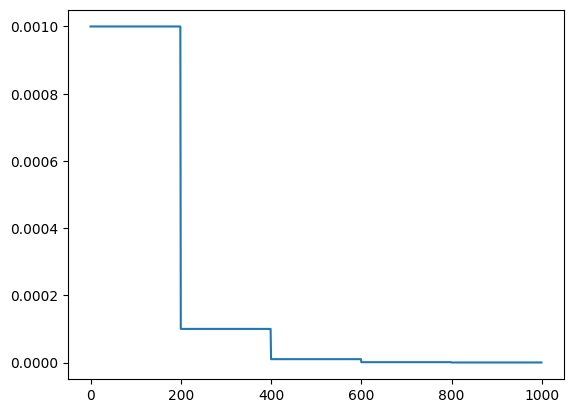

In [28]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

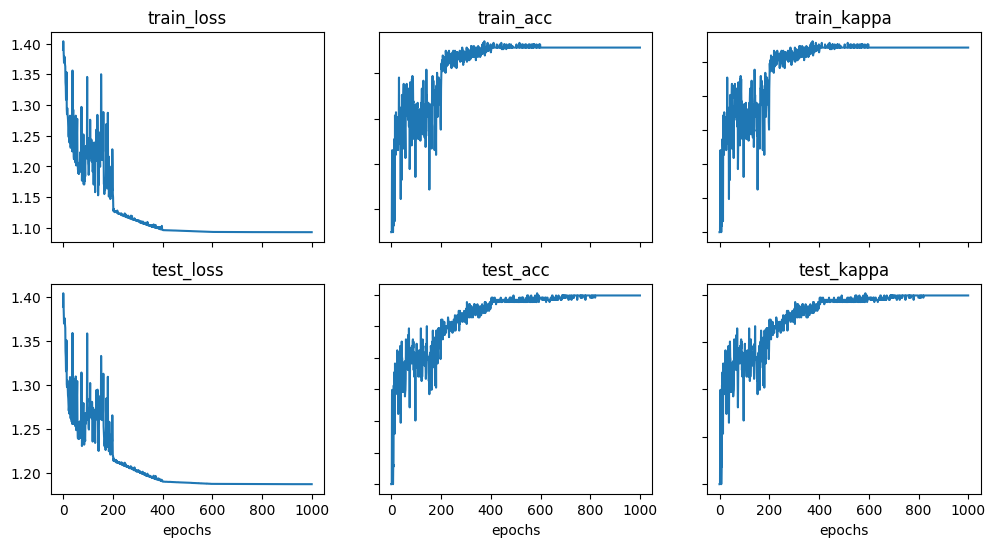

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

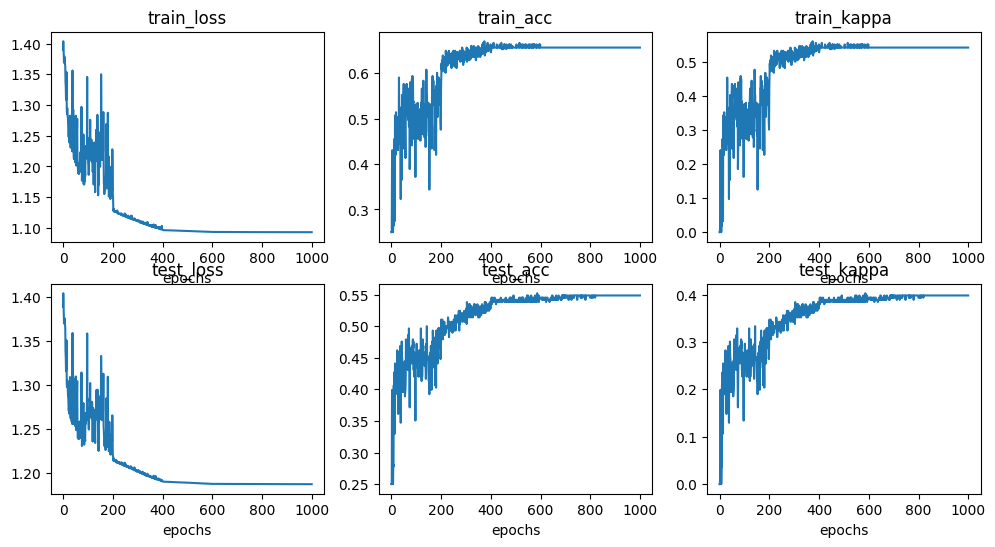

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()